# __Step 4.3: Topic model analysis__

Goals here:
- Get topic sizes
- Get top words for different topics
- Analyze connections between topics
- Analyze nature of outliers (in another step)
  - Interdisciplinary docs?
  - How to define interdisciplinarity?
- Analyze topics over time (in another step)

## ___Set up___

### Module import

In [156]:
import pickle, csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path
from bertopic import BERTopic
from tqdm import tqdm
from xlsxwriter.workbook import Workbook
#from pyvis.network import Network
from plotly.io import write_image
from sklearn.metrics.pairwise import cosine_similarity
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

### Key variables

In [227]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "4_topic_model/4_3_model_analysis"
work_dir.mkdir(parents=True, exist_ok=True)

# plant science corpus
dir25       = proj_dir / "2_text_classify/2_5_predict_pubmed"
corpus_file = dir25 / "corpus_plant_421658.tsv.gz"

# processed docs
dir41            = proj_dir / "4_topic_model/4_1_compare_models"
docs_clean_file  = dir41 / "corpus_plant_421658_proc_txt.pkl"

# saved model and probability file
dir42            = proj_dir / "4_topic_model/4_2_outlier_assign"
topic_model_file = dir42 / "topic_model_updated"
prob_file        = dir42 / "probs.pickle"
embedding_file   = dir42 / "embeddings_scibert.pickle"

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

## ___Load data___

### Load the plant science record corpus

In [228]:
corpus_df = pd.read_csv(corpus_file, sep='\t', compression='gzip')
corpus_df.head(2)

,Unnamed: 0,PMID,Date,Journal,Title,Abstract,QualifiedName,txt,reg_article,y_prob,y_pred
0,3,61,1975-12-11,Biochimica et biophysica acta,Identification of the 120 mus phase in the dec...,After a 500 mus laser flash a 120 mus phase in...,spinach,Identification of the 120 mus phase in the dec...,1,0.716394,1
1,4,67,1975-11-20,Biochimica et biophysica acta,Cholinesterases from plant tissues. VI. Prelim...,Enzymes capable of hydrolyzing esters of thioc...,plant,Cholinesterases from plant tissues. VI. Prelim...,1,0.894874,1


### Load cleaned data

In [4]:
with open(docs_clean_file, "rb") as f:
  docs_clean = pickle.load(f)

### Load topic model and probability

In [5]:
# Load topic model
topic_model = BERTopic.load(topic_model_file)

In [6]:
# load prob
with open(prob_file, "rb") as f:
  probs = pickle.load(f)

In [7]:
help(topic_model)

Help on BERTopic in module bertopic._bertopic object:

class BERTopic(builtins.object)
 |  BERTopic(language: str = 'english', top_n_words: int = 10, n_gram_range: Tuple[int, int] = (1, 1), min_topic_size: int = 10, nr_topics: Union[int, str] = None, low_memory: bool = False, calculate_probabilities: bool = False, diversity: float = None, seed_topic_list: List[List[str]] = None, embedding_model=None, umap_model: umap.umap_.UMAP = None, hdbscan_model: hdbscan.hdbscan_.HDBSCAN = None, vectorizer_model: sklearn.feature_extraction.text.CountVectorizer = None, verbose: bool = False)
 |  
 |  BERTopic is a topic modeling technique that leverages BERT embeddings and
 |  c-TF-IDF to create dense clusters allowing for easily interpretable topics
 |  whilst keeping important words in the topic descriptions.
 |  
 |  The default embedding model is `all-MiniLM-L6-v2` when selecting `language="english"` 
 |  and `paraphrase-multilingual-MiniLM-L12-v2` when selecting `language="multilingual"`.
 |  


## ___Basic summary___

### Topic size distribution

See Revisit topic size plot for an updated version used for graphics.

In [8]:
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name
0,-1,49228,-1_plant_plants_genes_cell
1,0,895,0_allergen_allergens_pollen_ige
2,1,2917,1_medium_callus_regeneration_mgl
3,2,1098,2_dots_fluorescence_detection_carbon dots
4,3,751,3_glyphosate_resistance_herbicide_herbicides
...,...,...,...
86,85,5989,85_soil_yield_nitrogen_water
87,86,4315,86_populations_genetic_selection_inbreeding
88,87,3737,87_pollen_pollination_flowers_floral
89,88,3807,88_populations_genetic_population_species


In [9]:
topic_counts = topic_info['Count'][1:]
max(topic_counts), min(topic_counts)

(16183, 620)

In [10]:
topic_info[topic_info['Count'] == max(topic_counts)]

,Topic,Count,Name
62,61,16183,61_qtl_resistance_chromosome_qtls


In [11]:
topic_info[topic_info['Count'] == min(topic_counts)]

,Topic,Count,Name
6,5,620,5_bp_chloroplast genome_complete chloroplast_g...


In [12]:
topic_info[topic_info['Topic'] == 35]

,Topic,Count,Name
36,35,13599,35_protein_proteins_cdna_sequence


In [13]:
topic_info[topic_info['Topic'] == 42]

,Topic,Count,Name
43,42,9745,42_genes_stress_proteins_transcriptome


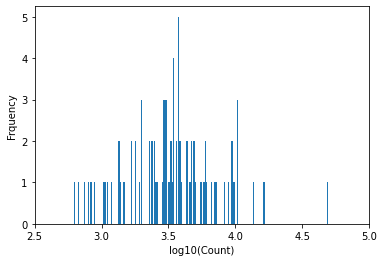

In [14]:
plt.hist(np.log10(topic_info["Count"]), bins=200)
plt.xlabel("log10(Count)")
plt.ylabel("Frquency")
plt.xlim(2.5,5)
plt.savefig(work_dir / "fig4_3_topic_count_dist.pdf")

### Representative docs

In [15]:
rep_docs = topic_model.get_representative_docs()

# So outlier topic is not included
type(rep_docs), len(rep_docs.keys()), len(rep_docs[0])

(dict, 90, 3)

In [16]:
# Write to a tsv
rep_docs_file = work_dir / "topic_rep_docs.tsv"
rep_docs_df   = pd.DataFrame.from_dict(rep_docs, orient='index',
                                  columns=['doc1', 'doc2', 'doc3'])
rep_docs_df.head()

,doc1,doc2,doc3
52,determination modification redox state seconda...,role beta-carotene reaction centres photosyste...,relationship photosynthetic electron transport...
48,isoenzymes glucose 6-phosphate dehydrogenase p...,purification characterization phytase cotyledo...,purification characterization acid phosphatase...
24,functions melatonin plants : review . number s...,compartment-specific importance ascorbate envi...,omics approach understand plant abiotic stress...
64,effect nonenzymatic protein lignocellulose enz...,"production , separation , characterization hig...",lignocellulose modifications brown rot fungi e...
18,hydrolysis 3'-terminal mispairs vitro 3 ' -- -...,wheat germ cytoplasmic ribosomes . localizatio...,differential stability zein mrna developing co...


In [17]:
rep_docs_df.to_csv(rep_docs_file, sep='\t')

## ___Get top words for different topics___

### generate_topic_labels

Get labels for each topic in a user-defined format
- Try nr_words=10
- E.g., cluster 5 does not make sense 

In [18]:
topic_labels = topic_model.generate_topic_labels(nr_words=10,
                                                 topic_prefix=True,
                                                 separator='|')

In [19]:
type(topic_labels), topic_labels[:10]

(list,
 ['-1|plant|plants|genes|cell|expression|gene|protein|cells|proteins|growth',
  '0|allergen|allergens|pollen|ige|patients|bet|allergy|allergenic|birch|allergic',
  '1|medium|callus|regeneration|mgl|ms|culture|somatic|explants|embryos|shoot',
  '2|dots|fluorescence|detection|carbon dots|carbon|quantum|cds|quantum dots|complexes|nm',
  '3|glyphosate|resistance|herbicide|herbicides|resistant|als|epsps|weed|accase|populations',
  '4|uvb|stress|plants|radiation|leaves|increased|light|water|growth|content',
  '5|bp|chloroplast genome|complete chloroplast|genome|chloroplast|complete|published informa|informa uk|informa|trading taylor',
  '6|cell|cells|imaging|microscopy|plant|proteins|protein|fluorescent|wall|fluorescence',
  '7|cells|cell|wall|pollen|cellulose|gravity|cytoplasm|cell wall|walls|microfibrils',
  '8|genome sequence|genome|draft|draft genome|strain|sequence|isolated|et al|et|complete genome'])

### get_topic

Return top 10 words for a specific topic and their c-TF-IDF scores

In [20]:
# Example
topic0 = topic_model.get_topic(0)
type(topic0)

list

In [21]:
topic0

[('allergen', 0.046134565528086965),
 ('allergens', 0.04381690521534331),
 ('pollen', 0.04282193073607554),
 ('ige', 0.03689159632358421),
 ('patients', 0.029150367742985052),
 ('bet', 0.021691721531794734),
 ('allergy', 0.019680880728313515),
 ('allergenic', 0.019457780271396177),
 ('birch', 0.018392410025878242),
 ('allergic', 0.01836639146722335)]

In [22]:
# Get all topic top 10 words, exclude the outlier cluster
# Ok, this can be done with top_model.get_topics()

#topic_top10 = {} # {cluster_id: top_10_list}
#for cluster_id in range(topic_info.shape[0]-1):
#  topic_top10[cluster_id] = topic_model.get_topic(cluster_id)


In [23]:
all_topics = topic_model.get_topics()
type(all_topics), all_topics[0]

(dict,
 [('allergen', 0.046134565528086965),
  ('allergens', 0.04381690521534331),
  ('pollen', 0.04282193073607554),
  ('ige', 0.03689159632358421),
  ('patients', 0.029150367742985052),
  ('bet', 0.021691721531794734),
  ('allergy', 0.019680880728313515),
  ('allergenic', 0.019457780271396177),
  ('birch', 0.018392410025878242),
  ('allergic', 0.01836639146722335)])

### Topic-term matrix

Follow [this](https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#topic-term-matrix)
- The approaches before only give the top 10 terms. Want to get more from each topic.
- So process the matrix instead.
- To get the top n entries per row, follow [this post](https://stackoverflow.com/questions/31790819/scipy-sparse-csr-matrix-how-to-get-top-ten-values-and-indices).
- Also, see [this post](https://stackoverflow.com/questions/3179106/python-select-subset-from-list-based-on-index-set) for selecting a subset from a list based on indices.


In [24]:
# Sparse matrix with topics as rows and features (i.e. terms) as columns, 
# values are c-Tf-idf
topic_term_matrix = topic_model.c_tf_idf

In [25]:
type(topic_term_matrix), topic_term_matrix.shape

(scipy.sparse.csr.csr_matrix, (91, 18850331))

### Top 50 terms for topics

In [26]:
# A list of features (terms)
terms = topic_model.vectorizer_model.get_feature_names()

In [27]:
type(terms), len(terms)

(list, 18850331)

In [28]:
# Get top 50 terms
top_50 = {} # {topic:[top50_idx_list, top50_c-tf-idf_list, to50_feat_list]}

# Skip the outlier topic, named the variable topic_plus1 because the topic
# index is -1 from the index in the topic_term_marix.
for topic_plus1 in tqdm(range(1, topic_term_matrix.shape[0])):
  row     = topic_term_matrix.getrow(topic_plus1).toarray()[0].ravel()

  # The following two lines sorted from low to high
  t50_idx = list(row.argsort()[-50:])
  t50_val = list(row[row.argsort()[-50:]])

  t50_fea = [terms[i] for i in t50_idx]
  top_50[topic_plus1-1] = [t50_idx, t50_val, t50_fea]

100%|██████████| 90/90 [01:39<00:00,  1.11s/it]


In [29]:
# Save the top 50 terms
with open(work_dir / 'top_50_terms_per_topic.pickle', 'wb') as f:
  pickle.dump(top_50, f)

### Save top terms for different topics into an xlsx file

See [this post](https://www.geeksforgeeks.org/convert-a-tsv-file-to-excel-using-python/) for saving TSVs into spreadsheet
- Also include a topic label sheet where label is the top 10 words
- Also include a representative doc sheet where the topic 3 docs of each topic is included.

In [30]:
xlsx_file = work_dir / "table_top_50.xlsx"
xlsx      = Workbook(xlsx_file)

In [31]:
# Incude the top 10 words in a worksheet
topic_label_file = work_dir / "topic_labels.txt"

# Do not output outlier
topic_label_df = pd.DataFrame(topic_labels[1:])
topic_label_df.columns = ["label"]
topic_label_df.to_csv(topic_label_file, sep='\t')

worksheet = xlsx.add_worksheet("topic_label")
read_tsv = csv.reader(open(topic_label_file,'r',encoding='utf-8'),delimiter='\t')
for row, data in enumerate(read_tsv):
  worksheet.write_row(row, 0, data)

In [32]:
# Incude the representative doc in a worksheet
worksheet = xlsx.add_worksheet("representative docs")
read_tsv = csv.reader(open(rep_docs_file,'r',encoding='utf-8'),delimiter='\t')
for row, data in enumerate(read_tsv):
  worksheet.write_row(row, 0, data)

In [33]:
# Put the top 50 term info into different tsv files in the top_50 folder
top_50_dir = work_dir / "top_50"
top_50_dir.mkdir(parents=True, exist_ok=True)

# Output individual tsv files and put tsv into xlsx
for topic in top_50:
  topic_file = top_50_dir / f"topic_{topic}.tsv"
  # The nested list has index, c-tf-idf, and feature as rows. So it is transposed
  # to have the rows as columns. The iloc bit is to reverse the order so higher
  # c-tf-idf entries are on top.
  topic_df = pd.DataFrame(top_50[topic]).transpose().iloc[::-1]
  topic_df.columns = ["index", "c-tf-idf", "feature"]
  topic_df.to_csv(topic_file, sep='\t')

  # Save to xlsx
  worksheet = xlsx.add_worksheet(f"{topic}")
  read_tsv  = csv.reader(open(topic_file, 'r',encoding='utf-8'),delimiter='\t')
  for row, data in enumerate(read_tsv):
    worksheet.write_row(row, 0, data)

xlsx.close()

## ___Visualize topic___

### Get topic assignments and words

In [221]:
# For hierachical_topics later, a list of topics is required. This is returned 
# by fit or fit_transform, but it does not make sense to run it again. So I get the
# topic cluster assignment based on probabilities.
probability_threshold = np.percentile(probs, 95)
record_topics = [np.argmax(prob) if max(prob) >= probability_threshold else -1 
                                                            for prob in probs]

In [37]:
topic_list   = sorted(record_topics)
all_topics   = sorted(list(topic_model.get_topics().keys()))
indices      = np.array([all_topics.index(topic) for topic in record_topics])
frequencies  = [topic_model.topic_sizes[topic] for topic in topic_list]

words = [" | ".join([word[0] for word in topic_model.get_topic(topic)[:5]]) 
                                                      for topic in topic_list]

### Topic relations in 2D

- visualize_topics:
  - This is useful to see how topics are related to each other in 2D.

In [ ]:
vis1 = topic_model.visualize_topics()
type(vis1)

In [ ]:
vis1

In [ ]:
vis1.write_html(work_dir / "fig4_3_topic_relation_2d.html")
write_image(vis1, work_dir / "fig4_3_topic_relation_2d.pdf", 
            format='pdf')

## ___Topic hierachical relations___

### Topic tree

In [38]:
hierarchical_topics = topic_model.hierarchical_topics(docs_clean, record_topics)

100%|██████████| 89/89 [00:37<00:00,  2.37it/s]


In [39]:
type(hierarchical_topics), hierarchical_topics.shape, hierarchical_topics.head()

(pandas.core.frame.DataFrame,
 (89, 8),
    Parent_ID                              Parent_Name  \
 88       178          plant_plants_species_gene_genes   
 87       177        gene_genetic_genes_genome_species   
 86       176     plant_plants_growth_activity_species   
 85       175  protein_expression_plant_activity_genes   
 84       174        gene_genetic_genes_genome_species   
 
                                                Topics Child_Left_ID  \
 88  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...           176   
 87  [0, 1, 2, 3, 5, 8, 9, 10, 11, 12, 13, 17, 21, ...           174   
 86  [4, 6, 7, 14, 15, 16, 18, 19, 20, 22, 24, 25, ...           175   
 85  [6, 7, 15, 16, 18, 19, 20, 22, 24, 25, 26, 27,...           168   
 84  [10, 11, 12, 17, 23, 36, 37, 38, 39, 40, 41, 5...           165   
 
                                    Child_Left_Name Child_Right_ID  \
 88            plant_plants_growth_activity_species            177   
 87               gene_genetic_genes

In [40]:
fig_hier_bot = topic_model.visualize_hierarchy(orientation="bottom")
fig_hier_bot.write_html(work_dir / "fig4_3_topic_hierarchy_bottom.html")

In [41]:
fig_hier_lef = topic_model.visualize_hierarchy(orientation="left")
fig_hier_lef.write_html(work_dir / "fig4_3_topic_hierarchy_left.html")

In [42]:
write_image(fig_hier_bot, work_dir / "fig4_3_topic_hierarchy_bottom.pdf", 
            format='pdf')
write_image(fig_hier_lef, work_dir / "fig4_3_topic_hierarchy_left.pdf", 
            format='pdf')

### Topic relations heatmap

This is not particularly helpful out of the box as the axes are not clustered.
- Look into [source code](https://github.com/MaartenGr/BERTopic/blob/master/bertopic/plotting/_heatmap.py) to see if I can get the distance matrix out and do my own.

In [43]:
fig_heatmap = topic_model.visualize_heatmap()
fig_heatmap.write_html(work_dir / "fig4_3_topic_heatmap.html")
write_image(fig_heatmap, work_dir / "fig4_3_topic_heatmap.pdf", 
            format='pdf')

### Topic relations heatmap - manual

In [44]:
# Load embeddings

# The following won't work because when I save the model, I did not save the
# embeddings. I did not save it because it is precomputed in 4.2.
#embeddings = np.array(topic_model.topic_embeddings)

# Load the saved embedding file
# The following won't work because it ask for >600Gb of memory when the distance
# matrix is being created.
#with open(embedding_file, "rb") as f:
#  embeddings = pickle.load(f)

# Realize that the embedding neededhere is the topic embedding, not doc 
# embedding. So the above is not useful. 
embeddings = topic_model.c_tf_idf

In [45]:
type(embeddings), embeddings.shape

(scipy.sparse.csr.csr_matrix, (91, 18850331))

In [46]:
freq_df = topic_model.get_topic_freq()
topics  = sorted(freq_df.Topic.to_list())

In [47]:
distance_matrix = cosine_similarity(embeddings)

In [74]:
dist_matrix_df = pd.DataFrame(distance_matrix,
                              index=topics,
                              columns=topics)

In [49]:
# Save the dataframe
dist_matrix_df.to_csv(work_dir / 'topic_dist_matrix_df.tsv', sep='\t')

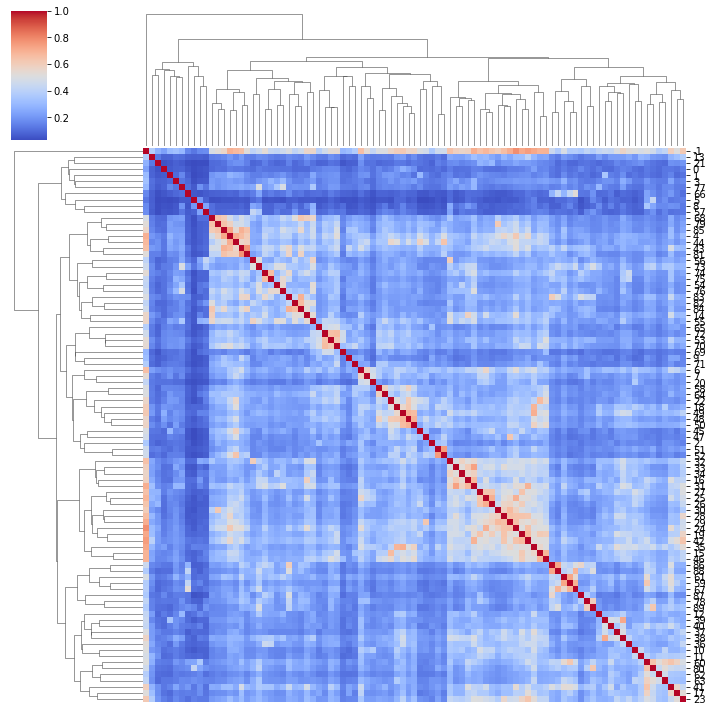

In [50]:
topic_clustergrid = sns.clustermap(dist_matrix_df, cmap="coolwarm", 
                                  xticklabels=False, yticklabels=True)
topic_clustergrid.savefig(work_dir / 'fig4_3_topic_heatmap_seaborn.pdf')

In [51]:
new_labels = [[[f"{topic}\t", None]] + topic_model.get_topic(topic) 
                                                    for topic in topics]
new_labels = ["|".join([label[0] for label in labels[:10]]) 
                                                    for labels in new_labels]
#new_labels = [label if len(label) < 30 else label[:27] + "..." 
#                                                    for label in new_labels]

In [52]:
new_labels[:2]

['-1\t|plant|plants|genes|cell|expression|gene|protein|cells|proteins',
 '0\t|allergen|allergens|pollen|ige|patients|bet|allergy|allergenic|birch']

In [53]:
# The returned order is in row index, not label or column names
order_idx   = topic_clustergrid.dendrogram_row.reordered_ind

# Create a list with each element containing topic labels
topic_order = [f"{new_labels[i]}" for i in order_idx]

# Write the topic order into a file
with open(work_dir / "fig4_3_topic_heatmap_seaborn_order.txt", "w") as f:
  f.write("\n".join(topic_order))

### Topic relations heatmap - lower half

Generate another version with only the lower half, see [this post](https://stackoverflow.com/questions/67879908/lower-triangle-mask-with-seaborn-clustermap) but did not lead to a figure. Try [this](https://medium.com/@fleetw00d/plotting-a-triangluar-portion-of-a-seaborn-clustermap-92f3405c2f4d).

In [54]:
mask   = np.tril(np.ones_like(dist_matrix_df))
values = topic_clustergrid.ax_heatmap.collections[0].get_array().reshape(
                                                          dist_matrix_df.shape)
new_values = np.ma.array(values, mask=mask)
topic_clustergrid.ax_heatmap.collections[0].set_array(new_values)
plt.show()

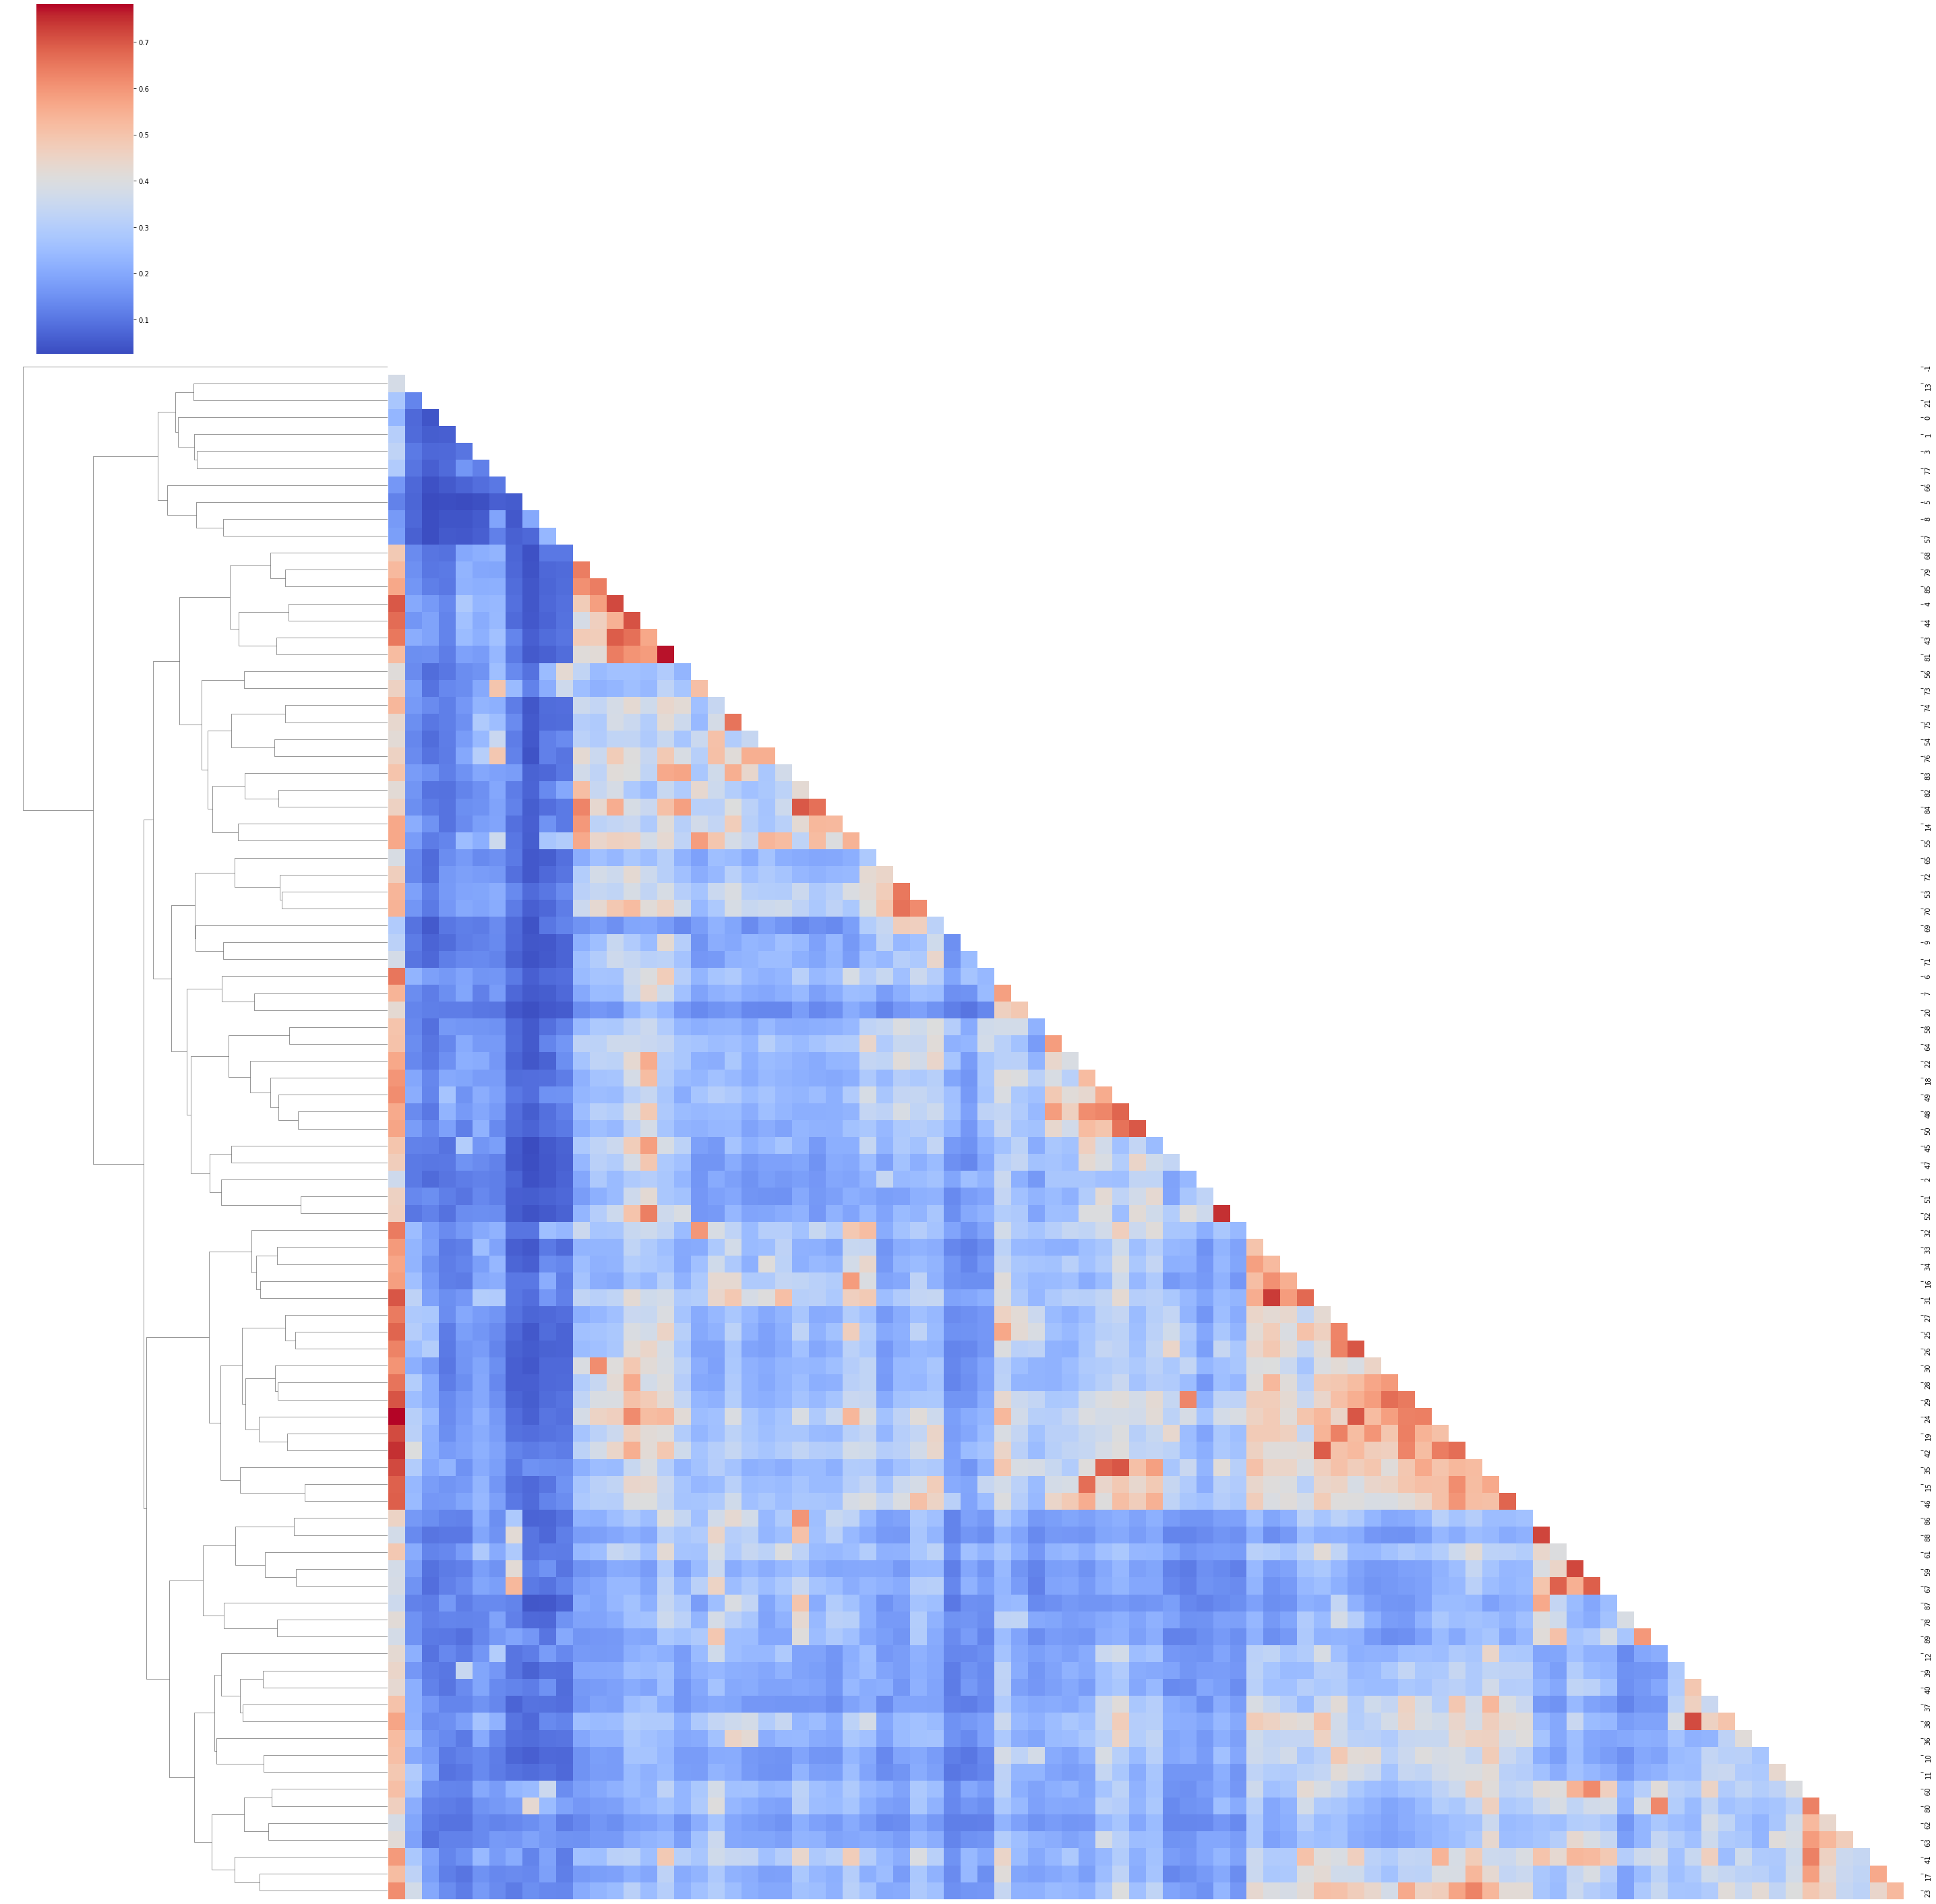

In [55]:
mask = np.zeros_like(dist_matrix_df)
mask[np.triu_indices_from(mask)] = True
g = sns.clustermap(dist_matrix_df, mask=mask, vmax=.3, figsize=(0.1,0.1))
mask = mask[np.argsort(g.dendrogram_row.reordered_ind),:]
mask = mask[:,np.argsort(g.dendrogram_col.reordered_ind)]
topic_clustergrid_lower = sns.clustermap(dist_matrix_df, 
                                         figsize=(40,40), mask=mask, 
                                         cmap='coolwarm', 
                                         xticklabels=False, 
                                         yticklabels=dist_matrix_df.columns)
topic_clustergrid_lower.ax_col_dendrogram.set_visible(False)
topic_clustergrid_lower.savefig(work_dir/'fig4_3_topic_heatmap_seaborn_lower.pdf')

### Modified top terms

Take `fig4_3_topic_heatmap_seaborn_order.txt`:
- Manually go through the terms to reduce redundancy and select 4-6 representative terms for each topic. The rules are:
  - Combine singular and plural forms (e.g., gene and genes)
  - Combine terms that are describing similar entities (e.g., strain and isolate)
  - Rid of overly common words (e.g., plant, gene in some cases)
- The result is in `fig4_3_topic_heatmap_seaborn_order_modified.txt`. Parse this so the info can be used as the topic names in the heatmap.

In [56]:
with open(work_dir / 'fig4_3_topic_heatmap_seaborn_order_modified.txt', 'r') as f:
  topic_modified = []
  lines = f.readlines()
  for line in lines:
    elements = line.strip().split("\t")
    ele_str  = f"{elements[0]}\t" # write the topic index
    for element in elements[1:]:
      if element != "":
        ele_str += f"{element} | "
    ele_str = ele_str[:-3]
    ele_str += "\n"
    topic_modified.append(ele_str)


In [57]:
with open(work_dir / 'fig4_3_topic_heatmap_seaborn_order_condensed.txt', 'w') as f:
  for topic in topic_modified:
    f.write(topic)

### Revisit topic size plot using the modified topic names

In [58]:
topic_info.head(2)

,Topic,Count,Name
0,-1,49228,-1_plant_plants_genes_cell
1,0,895,0_allergen_allergens_pollen_ige


In [59]:
# Ordered based on the index
topic_modified_ordered = [""]*len(topic_modified)
for topic_name in topic_modified:
  [topic, name] = topic_name.strip().split('\t')
  topic_modified_ordered[int(topic)+1] = f"{topic}: {name}"
topic_modified_ordered[:5]

['-1: cell | expression | gene | protein',
 '0: allergen | pollen | ige | allergenic',
 '1: medium | callus | regeneration | culture | somatic',
 '2: fluorescence | detection | carbon dots | quantum dots',
 '3: glyphosate | resistance | herbicide | epsps | weed']

In [60]:
topic_modified_ordered[0] = "OUTLIER"

In [61]:
topic_info['Modified'] = topic_modified_ordered
topic_info.head(2)

,Topic,Count,Name,Modified
0,-1,49228,-1_plant_plants_genes_cell,OUTLIER
1,0,895,0_allergen_allergens_pollen_ige,0: allergen | pollen | ige | allergenic


In [62]:
topic_info.sort_values('Count', inplace=True)
topic_info.head(2)

,Topic,Count,Name,Modified
6,5,620,5_bp_chloroplast genome_complete chloroplast_g...,5: chloroplast genome
67,66,673,66_microsatellite_markers_microsatellite marke...,66: microsatellite markers | loci | polymorphi...


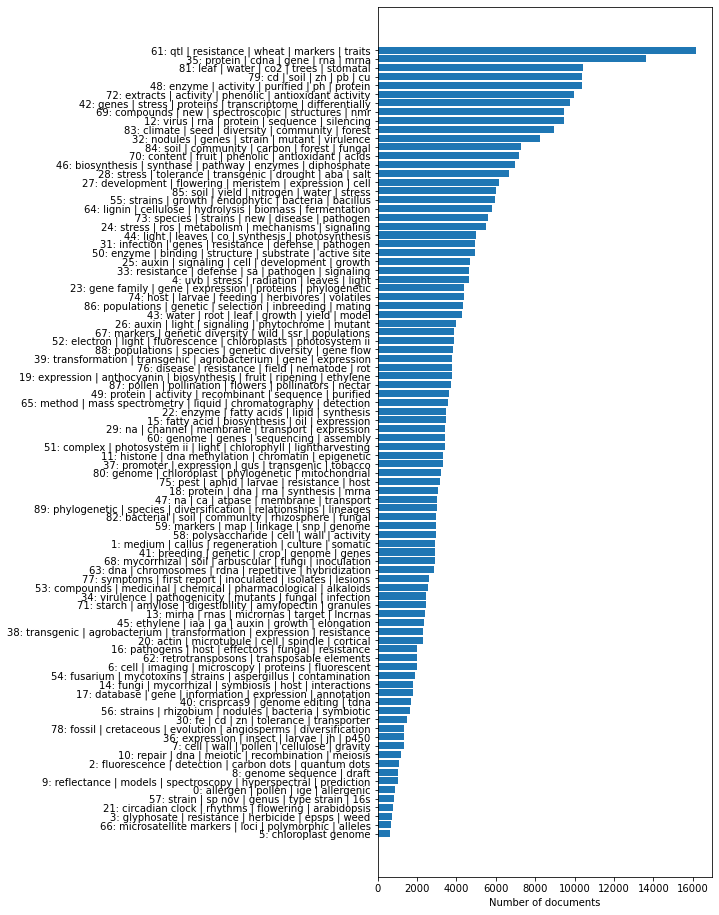

In [63]:
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html

# Do not plot outliers
fig, ax = plt.subplots(figsize=(6,16))
y_pos = np.arange(topic_info.shape[0]-1)
ax.barh(y_pos, topic_info['Count'][:-1], align='center')
ax.set_yticks(y_pos, labels=topic_info['Modified'][:-1])
ax.set_xlabel("Number of documents")
plt.savefig(work_dir / "fig4_3_number_docs_per_topic.pdf")
plt.show()

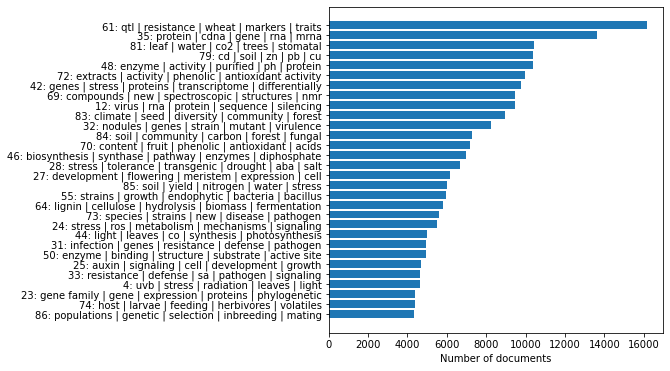

In [64]:
# Plot top 30
top_n   = 30
fig, ax = plt.subplots(figsize=(6,6))
y_pos = np.arange(top_n)
ax.barh(y_pos, topic_info['Count'][-top_n-1:-1], align='center')
ax.set_yticks(y_pos, labels=topic_info['Modified'][-top_n-1:-1])
ax.set_xlabel("Number of documents")
plt.savefig(work_dir / f"fig4_3_number_docs_per_topic_top{top_n}.pdf")
plt.show()

In [65]:
topic_info['Count'][-top_n-1:-1]

87     4315
75     4384
24     4405
5      4616
34     4640
26     4700
51     4927
32     4950
45     5007
25     5486
74     5590
65     5821
56     5961
86     5989
28     6163
29     6680
47     6956
71     7180
85     7289
33     8251
84     8930
13     9471
70     9471
43     9745
73     9951
49    10369
80    10390
82    10403
36    13599
62    16183
Name: Count, dtype: int64

In [66]:
topic_info[topic_info["Topic"] == 72]

,Topic,Count,Name,Modified
73,72,9951,72_antioxidant_extracts_extract_activity,72: extracts | activity | phenolic | antioxida...


## ___Topic network graph___

### Get source-target dataframe

See [this post](https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259)

In [197]:
def get_src_tar_df(cos_sim_threshold=0.6, name="topic"):
  '''Create a four-column dataframe with: Source, Target, Type, weight.
  Args:
    cos_sim_threshold (float): if the cosine similarity of two topics is above
      threshold, it will be included in the dataframe.
    name (str): topic - the original topic name in the form of index, or
      modified - the modified names with top terms associated with them.
  Return:
    network_nodes_df (pd dataframe)
    weights (nd array): the weight column, for specifying edge color
    widths (nd array): for specifying edge width
  '''

  # Replace column names with modified topic names
  dist_matrix_df.columns = topic_modified_ordered
  edge_type = "Undirected"

  # A nested list with info for each node pair
  network_nodes = [] # [[Source, Target, Type, weight]]

  # iterate through topic pairs, non-redundant and non-self. Skip outlier topic
  for src_idx in range(1, 90):
    for tar_idx in range(src_idx+1, 90):
      cos_sim = dist_matrix_df.iloc[src_idx][tar_idx]
      if cos_sim > cos_sim_threshold:
        if name == "topic":
          # With topic number
          network_nodes.append([src_idx-1, tar_idx-1, edge_type, cos_sim])
        else:
          # With full modified names
          network_nodes.append([topic_modified_ordered[src_idx],
                                 topic_modified_ordered[tar_idx],
                                edge_type, cos_sim])

  network_nodes_df = pd.DataFrame(network_nodes, 
                                columns=['Source', 'Target', 'Type', 'weight'])

  # the weight column
  weights = network_nodes_df['weight'].values

  # get edge width
  # Set edge width, scale between 1 and 5
  widths  = np.array(weights)
  min_w   = min(w_array)
  max_w   = max(w_array)
  # 0-1 scaling
  widths = (w_array - min_w)/(max_w - min_w)*10
  
  return network_nodes_df, weights, widths
  

In [198]:
# with topic name in index form
network_nodes_df, weights, widths = get_src_tar_df(cos_sim_threshold=0.6, 
                                                   name="topic")
network_nodes_df.head(2)

,Source,Target,Type,weight
0,4,24,Undirected,0.61691
1,4,43,Undirected,0.66257


In [200]:
# With topic names containing top terms
network_nodes_df2, _, _ = get_src_tar_df(cos_sim_threshold=0.6, 
                                                   name="modified")
network_nodes_df2.head(2)

,Source,Target,Type,weight
0,4: uvb | stress | radiation | leaves | light,24: stress | ros | metabolism | mechanisms | s...,Undirected,0.61691
1,4: uvb | stress | radiation | leaves | light,43: water | root | leaf | growth | yield | model,Undirected,0.66257


In [188]:
weights[:2], widths[:2]

(array([0.61690998, 0.66257021]), array([0.97671316, 3.65813627]))

### Plot graphs with networkx

- See [this](https://stackoverflow.com/questions/22967086/colouring-edges-by-weight-in-networkx) about color edges based on weight.

In [192]:
def draw_graph(df, weights, widths, name_ext=""):
  # Create graph obj
  G = nx.from_pandas_edgelist(df, source='Source', target='Target', 
                              edge_attr='weight')
  
  plt.figure(figsize=(10,10))

  # So set cmap works here, but does not work when pass as an argument in nx.draw
  # with edge_cmpa="coolwarm"
  plt.set_cmap("RdPu")

  # TypeError: argument of type 'float' is not iterable
  #pos = nx.nx_pydot.graphviz_layout(G) 
  #pos = nx.nx_pydot.pydot_layout(G)
  # AmbiguousSolution: Disconnected graph: Ambiguous solution for bipartite sets.
  #top = nx.bipartite.sets(G)[0]
  #pos = nx.bipartite_layout(G, top)
  # NetworkXException: G is not planar.
  #pos = nx.planar_layout(G)

  # Tried and worked but don't like them, in order of preference
  #pos = nx.spring_layout(G, seed=seed)
  #pos = nx.kamada_kawai_layout(G)
  #pos = nx.circular_layout(G)
  #pos = nx.random_layout(G)
  #pos = nx.spectral_layout(G)
  #pos = nx.spiral_layout(G)

  pos = nx.spring_layout(G, seed=seed)
  
  # Drwa and save network figure
  nx.draw(G, pos, with_labels=True, edge_color=weights, width=widths)
  plt.savefig(work_dir / f"fig4_3_topic_network_{name_ext}.pdf")
  plt.show()

  # Draw and save colorbar
  #https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
  #https://stackoverflow.com/questions/35444858/python-matplotlib-add-legend-for-a-colormap
  plt.imshow(weights.reshape(weights.shape[0],1), cmap="RdPu")
  plt.colorbar()
  plt.savefig(work_dir / f"fig4_3_topic_network_{name_ext}_colorbar.pdf")
  plt.show()


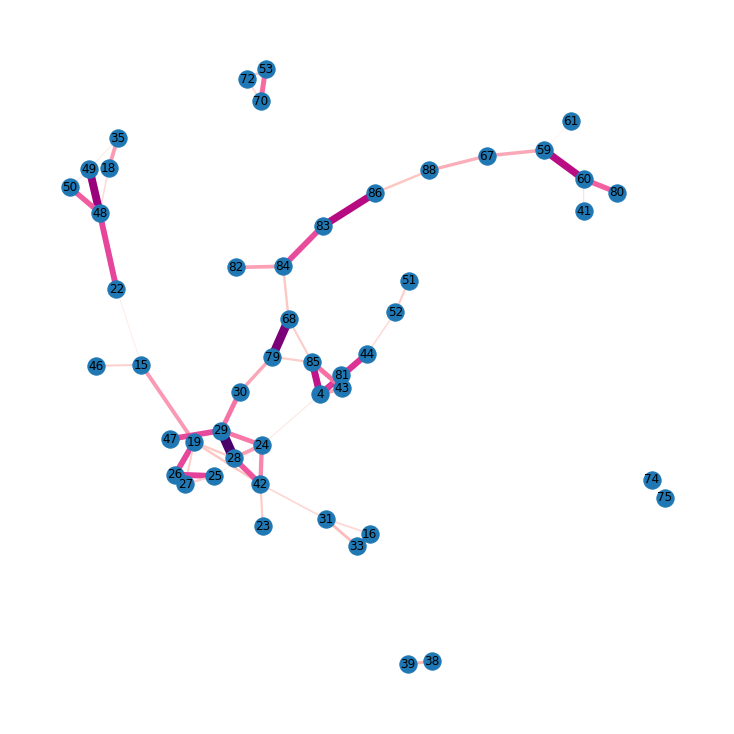

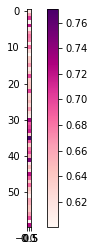

In [193]:
draw_graph(network_nodes_df, weights, widths, name_ext="oriname")


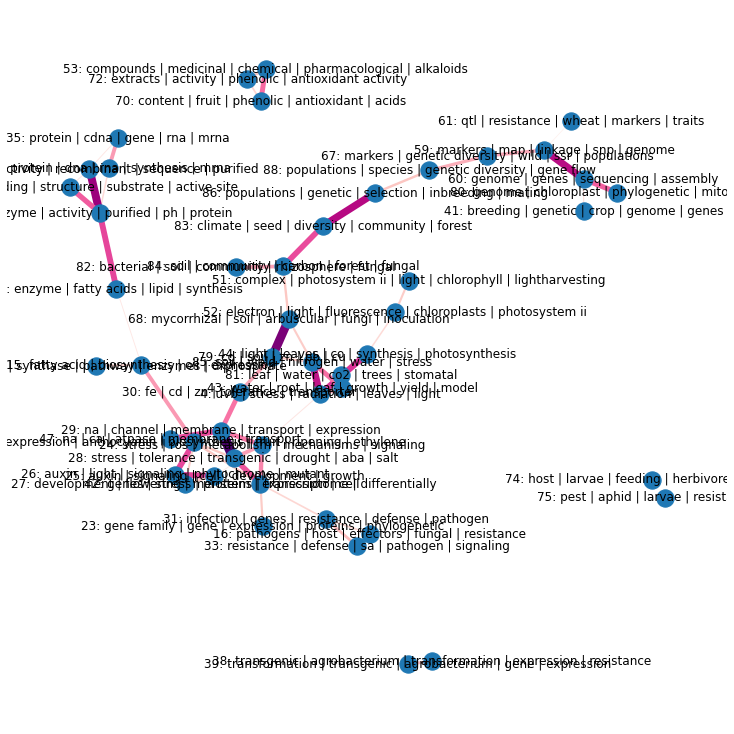

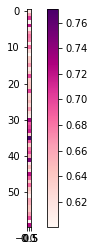

In [201]:
draw_graph(network_nodes_df2, weights, widths, name_ext="modified")

### Plot graph with PyVis

The libarary cannot be installed in the current environment (torch_default). Do this in an independent graphing environment. 
- Do this in 4.3b.
- Did not finish, PyVis install in WSL is problematic.

### Median cosine similarities

To see which topics are among the most well connected.

### Median cosine similarities

To see which topics are among the most well connected.

In [ ]:
dist_matrix_df.head(2)

,OUTLIER,0: allergen | pollen | ige | allergenic,1: medium | callus | regeneration | culture | somatic,2: fluorescence | detection | carbon dots | quantum dots,3: glyphosate | resistance | herbicide | epsps | weed,4: uvb | stress | radiation | leaves | light,5: chloroplast genome,6: cell | imaging | microscopy | proteins | fluorescent,7: cell | wall | pollen | cellulose | gravity,8: genome sequence | draft,...,80: genome | chloroplast | phylogenetic | mitochondrial,81: leaf | water | co2 | trees | stomatal,82: bacterial | soil | community | rhizosphere | fungal,83: climate | seed | diversity | community | forest,84: soil | community | carbon | forest | fungal,85: soil | yield | nitrogen | water | stress,86: populations | genetic | selection | inbreeding | mating,87: pollen | pollination | flowers | pollinators | nectar,88: populations | species | genetic diversity | gene flow,89: phylogenetic | species | diversification | relationships | lineages
-1,1.000000,0.230215,0.306080,0.360142,0.326895,0.697370,0.121420,0.653429,0.538960,0.170015,...,0.465465,0.521564,0.421212,0.498473,0.459841,0.56549,0.451429,0.357277,0.371526,0.375525
0,0.230215,1.000000,0.059948,0.097817,0.077573,0.132975,0.030327,0.165746,0.146288,0.041373,...,0.112730,0.111975,0.093202,0.114618,0.096515,0.10289,0.124883,0.166121,0.103438,0.102657


In [ ]:
dist_matrix_df_nooutlier = dist_matrix_df.iloc[1:,1:]
dist_matrix_df_nooutlier.head(2)

,0: allergen | pollen | ige | allergenic,1: medium | callus | regeneration | culture | somatic,2: fluorescence | detection | carbon dots | quantum dots,3: glyphosate | resistance | herbicide | epsps | weed,4: uvb | stress | radiation | leaves | light,5: chloroplast genome,6: cell | imaging | microscopy | proteins | fluorescent,7: cell | wall | pollen | cellulose | gravity,8: genome sequence | draft,9: reflectance | models | spectroscopy | hyperspectral | prediction,...,80: genome | chloroplast | phylogenetic | mitochondrial,81: leaf | water | co2 | trees | stomatal,82: bacterial | soil | community | rhizosphere | fungal,83: climate | seed | diversity | community | forest,84: soil | community | carbon | forest | fungal,85: soil | yield | nitrogen | water | stress,86: populations | genetic | selection | inbreeding | mating,87: pollen | pollination | flowers | pollinators | nectar,88: populations | species | genetic diversity | gene flow,89: phylogenetic | species | diversification | relationships | lineages
0,1.000000,0.059948,0.097817,0.077573,0.132975,0.030327,0.165746,0.146288,0.041373,0.084447,...,0.112730,0.111975,0.093202,0.114618,0.096515,0.102890,0.124883,0.166121,0.103438,0.102657
1,0.059948,1.000000,0.114056,0.097219,0.287108,0.025724,0.188176,0.193587,0.040581,0.111999,...,0.102731,0.183551,0.124212,0.151351,0.144418,0.222929,0.121862,0.111405,0.103469,0.089613


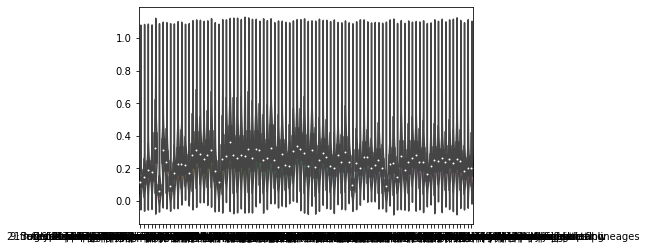

In [ ]:
# Plot is not particularly useful
ax = sns.violinplot(data=dist_matrix_df_nooutlier)

In [ ]:
# Calculate median values
#https://datascienceparichay.com/article/pandas-get-median-of-one-or-more-columns/
topic_medians = dist_matrix_df_nooutlier.median()
topic_medians_sorted = topic_medians.sort_values()
topic_medians_sorted[:10], topic_medians_sorted[-10:]

(5: chloroplast genome                                                  0.060071
 8: genome sequence | draft                                             0.091145
 66: microsatellite markers | loci | polymorphic | alleles              0.094544
 57: strain | sp nov | genus | type strain | 16s                        0.100107
 0: allergen | pollen | ige | allergenic                                0.115677
 21: circadian clock | rhythms | flowering | arabidopsis                0.118822
 1: medium | callus | regeneration | culture | somatic                  0.149968
 69: compounds | new | spectroscopic | structures | nmr                 0.149971
 77: symptoms | first report | inoculated | isolates | lesions          0.167185
 9: reflectance | models | spectroscopy | hyperspectral | prediction    0.168736
 dtype: float64,
 19: expression | anthocyanin | biosynthesis | fruit | ripening | ethylene    0.314657
 15: fatty acid | biosynthesis | oil | expression                             0.314754

In [ ]:
topic_medians.to_csv(work_dir / "fig4_3b_topic_cosine_sim_median.txt", sep='\t')

In [202]:
dist_matrix_df.head(2)

,OUTLIER,0: allergen | pollen | ige | allergenic,1: medium | callus | regeneration | culture | somatic,2: fluorescence | detection | carbon dots | quantum dots,3: glyphosate | resistance | herbicide | epsps | weed,4: uvb | stress | radiation | leaves | light,5: chloroplast genome,6: cell | imaging | microscopy | proteins | fluorescent,7: cell | wall | pollen | cellulose | gravity,8: genome sequence | draft,...,80: genome | chloroplast | phylogenetic | mitochondrial,81: leaf | water | co2 | trees | stomatal,82: bacterial | soil | community | rhizosphere | fungal,83: climate | seed | diversity | community | forest,84: soil | community | carbon | forest | fungal,85: soil | yield | nitrogen | water | stress,86: populations | genetic | selection | inbreeding | mating,87: pollen | pollination | flowers | pollinators | nectar,88: populations | species | genetic diversity | gene flow,89: phylogenetic | species | diversification | relationships | lineages
-1,1.000000,0.230215,0.306080,0.360142,0.326895,0.697370,0.121420,0.653429,0.538960,0.170015,...,0.465465,0.521564,0.421212,0.498473,0.459841,0.56549,0.451429,0.357277,0.371526,0.375525
0,0.230215,1.000000,0.059948,0.097817,0.077573,0.132975,0.030327,0.165746,0.146288,0.041373,...,0.112730,0.111975,0.093202,0.114618,0.096515,0.10289,0.124883,0.166121,0.103438,0.102657


In [205]:
dist_matrix_df_nooutlier = dist_matrix_df.iloc[1:,1:]
dist_matrix_df_nooutlier.head(2)

,0: allergen | pollen | ige | allergenic,1: medium | callus | regeneration | culture | somatic,2: fluorescence | detection | carbon dots | quantum dots,3: glyphosate | resistance | herbicide | epsps | weed,4: uvb | stress | radiation | leaves | light,5: chloroplast genome,6: cell | imaging | microscopy | proteins | fluorescent,7: cell | wall | pollen | cellulose | gravity,8: genome sequence | draft,9: reflectance | models | spectroscopy | hyperspectral | prediction,...,80: genome | chloroplast | phylogenetic | mitochondrial,81: leaf | water | co2 | trees | stomatal,82: bacterial | soil | community | rhizosphere | fungal,83: climate | seed | diversity | community | forest,84: soil | community | carbon | forest | fungal,85: soil | yield | nitrogen | water | stress,86: populations | genetic | selection | inbreeding | mating,87: pollen | pollination | flowers | pollinators | nectar,88: populations | species | genetic diversity | gene flow,89: phylogenetic | species | diversification | relationships | lineages
0,1.000000,0.059948,0.097817,0.077573,0.132975,0.030327,0.165746,0.146288,0.041373,0.084447,...,0.112730,0.111975,0.093202,0.114618,0.096515,0.102890,0.124883,0.166121,0.103438,0.102657
1,0.059948,1.000000,0.114056,0.097219,0.287108,0.025724,0.188176,0.193587,0.040581,0.111999,...,0.102731,0.183551,0.124212,0.151351,0.144418,0.222929,0.121862,0.111405,0.103469,0.089613


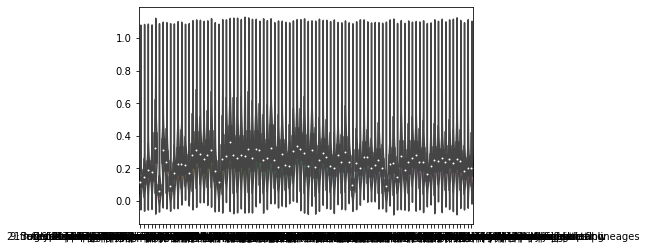

In [208]:
# Plot is not particularly useful
ax = sns.violinplot(data=dist_matrix_df_nooutlier)

In [219]:
# Calculate median values
#https://datascienceparichay.com/article/pandas-get-median-of-one-or-more-columns/
topic_medians = dist_matrix_df_nooutlier.median()
topic_medians_sorted = topic_medians.sort_values()
topic_medians_sorted[:10], topic_medians_sorted[-10:]

(5: chloroplast genome                                                  0.060071
 8: genome sequence | draft                                             0.091145
 66: microsatellite markers | loci | polymorphic | alleles              0.094544
 57: strain | sp nov | genus | type strain | 16s                        0.100107
 0: allergen | pollen | ige | allergenic                                0.115677
 21: circadian clock | rhythms | flowering | arabidopsis                0.118822
 1: medium | callus | regeneration | culture | somatic                  0.149968
 69: compounds | new | spectroscopic | structures | nmr                 0.149971
 77: symptoms | first report | inoculated | isolates | lesions          0.167185
 9: reflectance | models | spectroscopy | hyperspectral | prediction    0.168736
 dtype: float64,
 19: expression | anthocyanin | biosynthesis | fruit | ripening | ethylene    0.314657
 15: fatty acid | biosynthesis | oil | expression                             0.314754

In [218]:
topic_medians.to_csv(work_dir / "fig4_3b_topic_cosine_sim_median.txt", sep='\t')

## ___Compare pairs of topics___

### Topic correlation scatter plot

The c-Tf-Idf values are multiplied by 1,000 so it is easier to read.

In [ ]:
def topic_pair_scatter(topic_term_matrix, topic_pair, top_50, out_file,
                       t_annotate=6):
  '''Generate and save a scatter plot of the top50 c-Tf-Idfs of a topic pair
  Args:
   topic_term_matrix (csr): A sparse matrix returned from topic_model.c_tf_idf
   top_50 (dict): {topic:[t50_idx, t50_val, t50_fea]}
   topic_pair (list): a pair of topic indices (-1, ..., 90) in a list
   out_file (str): output pdf name
   t_annotate (float): threshold c-Tf-Idfx1000 values to show feature annotation
  Returns:
  Output:
    out_file (pdf): the scatter plot. 
  '''
  [topic1, topic2] = topic_pair

  # combined top 50 indices
  idx1 = top_50[topic1][0]
  idx2 = top_50[topic2][0]
  top_50_both = list(set(idx1 + idx2))
  #print(len(top_50_both))

  # Get the feature names of indices in the combined list
  top_50_both_feats = []
  feat1 = top_50[topic1][2]
  feat2 = top_50[topic2][2]
  for idx in top_50_both:
    if idx in idx1:
      idx_idx1 = idx1.index(idx)
      top_50_both_feats.append(feat1[idx_idx1])
    elif idx in idx2:
      idx_idx2 = idx2.index(idx)
      top_50_both_feats.append(feat2[idx_idx2])
    else:
      print("ERR: idx {idx} not found")      

  # Get all feature ctfidf values. Note that topic_term_matrix include the -1 
  # topic, so the index of topic 0 should have a row index of 1 in the matrix, 
  # so +1 in the getrow bit below.
  row1 = topic_term_matrix.getrow(topic1+1).toarray()[0].ravel()
  row2 = topic_term_matrix.getrow(topic2+1).toarray()[0].ravel()

  ctfidf1 = row1[top_50_both]*1e3
  ctfidf2 = row2[top_50_both]*1e3
  #print(ctfidf1, ctfidf2)

  # For setting the x, y limits
  #ctfidf_max = math.ceil(max([max(ctfidf1), max(ctfidf2)]))
  #print(ctfidf_max)
  ctfidf_max=12

  plt.figure(figsize=(5,5))
  plt.scatter(ctfidf1, ctfidf2)
  plt.xlabel(f"topic {topic1} c-Tf-Idf (x1,000)")
  plt.ylabel(f"topic {topic2} c-Tf-Idf (x1,000)")
  plt.plot([0, ctfidf_max], [0, ctfidf_max], 'ro--')
  plt.xlim(0, ctfidf_max)
  plt.ylim(0, ctfidf_max)

  for idx, label in enumerate(top_50_both_feats):
    x = ctfidf1[idx]
    y = ctfidf2[idx]
    # Only annotate if the values are larger
    if  x >= t_annotate or y >= t_annotate:
      # annotate labels out of boundary
      if x > ctfidf_max or y > ctfidf_max:
        if x > ctfidf_max and y > ctfidf_max:
            new_x = new_y = ctfidf_max
        elif x > ctfidf_max:
          new_x = ctfidf_max
          new_y = y
        else:
          new_x = x
          new_y = ctfidf_max
        plt.arrow(new_x-0.6, new_y-0.6, 0.5, 0.5, 
                  width=0.05, head_width=0.2, ec="purple")
        plt.annotate(f"{label}({x},{y})", (new_x, new_y), fontsize=6)
      # for points within boundary
      else:
        plt.annotate(label, (x, y), fontsize=6)
  out_file = work_dir / f"fig4_3_topic_pair_scatter_{topic1}_{topic2}.pdf"
  plt.savefig(out_file)
  


### Illustrate similarities between topics in a "super-cluster"

- Topic 74, 75: host, larve, herbivore, pest, host
- Topic 4, 44: uvb, stress, light, leave, co
- Topic 25, 26, 27

In [ ]:
pair1 = [74, 75]
pair2 = [4, 44]
pair3 = [25, 26]
pair4 = [25, 27]
pair5 = [26, 27]

In [ ]:
topic_pair_scatter(topic_term_matrix, pair1, top_50, 5.5)

In [ ]:
topic_pair_scatter(topic_term_matrix, pair2, top_50, 5.5)
topic_pair_scatter(topic_term_matrix, pair3, top_50, 5.5)
topic_pair_scatter(topic_term_matrix, pair4, top_50, 5.5)
topic_pair_scatter(topic_term_matrix, pair5, top_50, 5.5)

In [ ]:
pair11 = [86, 88]
topic_pair_scatter(topic_term_matrix, pair11, top_50, 5.5)

### Illustrate similarities between topics not in a "super-cluster"

- Topic 25, 6: auxin signaling, microscopy
- Topic 22, 15, lipid, oil
- Topic 4, 24: uvb stress, ros, metabolism
- Topic 44, 52: light, leaves, co, electron, light
- Topic 44, 51: 51 and 52 are highly similar, but not between 44 and 51

In [ ]:
pair6 = [25, 6]
pair7 = [22, 15]
pair8 = [4, 24]
pair9 = [44, 52]
pair10 = [44, 51]

In [ ]:
topic_pair_scatter(topic_term_matrix, pair6, top_50, 5.5)
topic_pair_scatter(topic_term_matrix, pair7, top_50, 5.5)
topic_pair_scatter(topic_term_matrix, pair8, top_50, 5.5)
topic_pair_scatter(topic_term_matrix, pair9, top_50, 5.5)
topic_pair_scatter(topic_term_matrix, pair10, top_50, 5.5)

### Make sure the topic assignment, corpus_df, and docs_clean are in sync

In [241]:
len(record_topics), record_topics[:5]

(421658, [52, 48, 48, 48, 47])

In [238]:
corpus_df.shape

(421658, 11)

In [240]:
corpus_df.head(1)

,Unnamed: 0,PMID,Date,Journal,Title,Abstract,QualifiedName,txt,reg_article,y_prob,y_pred
0,3,61,1975-12-11,Biochimica et biophysica acta,Identification of the 120 mus phase in the dec...,After a 500 mus laser flash a 120 mus phase in...,spinach,Identification of the 120 mus phase in the dec...,1,0.716394,1


In [234]:
# Make sure the order of docs are the same
corpus_df['txt'][:2], corpus_df['txt'][-2:]

(0    Identification of the 120 mus phase in the dec...
 1    Cholinesterases from plant tissues. VI. Prelim...
 Name: txt, dtype: object,
 421656    QDtbn1 , an F-box gene affecting maize tassel ...
 421657    A global survey of the gene network and key ge...
 Name: txt, dtype: object)

In [236]:
docs_clean[0][:50], docs_clean[1][:50], docs_clean[-2][:50], docs_clean[-1][:50] 

('identification 120 mus phase decay delayed fluores',
 'cholinesterases plant tissues . vi . preliminary c',
 'qdtbn1 , f-box gene affecting maize tassel branch ',
 'global survey gene network key genes oil accumulat')

### Build a dataframe with topic counts for each journal

In [255]:
for idx, toc in enumerate(record_topics):
  print(idx, toc)
  break

0 52


In [270]:
record_journals = corpus_df['Journal']
unique_journals = record_journals.unique()
unique_journals.shape, unique_journals

((3538,),
 array(['Biochimica et biophysica acta', 'Folia microbiologica',
        'Journal of biochemistry', ...,
        'Estuaries and coasts : journal of the Estuarine Research Federation',
        'Journal of agricultural science (Toronto, Ont.)',
        'International journal of plant &amp; soil science'], dtype=object))

In [275]:
# fill in data in dict_toc_jr
dict_toc_jr = {} # {toc: [journal_count]}

# iterate through record idx and toc
for idx, toc in enumerate(record_topics):
  # exclude topic -1:
  if toc != -1:
    # journal of this record
    jr     = record_journals[idx]
    # journal's index in unique_journals list
    #jr_idx = np.where(unique_journals == jr)   
    
    # new topic
    if toc not in dict_toc_jr:
      dict_toc_jr[toc] = {jr:1}
    elif jr not in dict_toc_jr[toc]:
      dict_toc_jr[toc][jr] = 1
    else:
      dict_toc_jr[toc][jr]+= 1


In [276]:
# Now, fill in 0s for journals not in a topic
for toc in dict_toc_jr:
  for jr in unique_journals:
    if jr not in dict_toc_jr[toc]:
      dict_toc_jr[toc][jr] = 0

In [277]:
df_toc_jr = pd.DataFrame.from_dict(dict_toc_jr)
df_toc_jr.head()

,52,48,47,32,24,22,58,18,64,71,...,26,28,33,9,31,66,8,13,17,5
Biochimica et biophysica acta,318,479,131,20,58,170,19,102,2,3,...,3,12,5,1,1,0,0,9,0,0
The Biochemical journal,59,436,42,10,19,180,52,73,1,0,...,4,6,2,0,0,0,0,0,0,0
"Biokhimiia (Moscow, Russia)",30,78,8,0,0,13,0,21,3,0,...,0,0,0,0,0,0,0,0,0,0
European journal of biochemistry,34,357,38,3,4,71,26,148,0,0,...,0,0,1,0,0,0,0,0,0,0
Die Naturwissenschaften,1,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Get the top x journals

Get top 20

In [293]:
record_journal_total = df_toc_jr.sum(axis=1)
record_journal_total[:2], record_journal_total[-2:]

(Biochimica et biophysica acta    2429
 The Biochemical journal          1417
 dtype: int64,
 Journal of agricultural science (Toronto, Ont.)      1
 International journal of plant &amp; soil science    1
 dtype: int64)

In [294]:
# Get top x
top_x     = 20
top_x_idx = np.argpartition(record_journal_total.values, -top_x)[-top_x:]
top_x_idx

array([  96,  190,  155,    6,  180,  146,   89,   12,  121,  231,  218,
         77,   97,   72,   59,  182, 3248,  199,  209,   73])

In [295]:
df_toc_jr_topx = df_toc_jr.iloc[top_x_idx]
df_toc_jr_topx.shape, 

((20, 90),)

In [296]:
df_toc_jr_topx[:2]

,52,48,47,32,24,22,58,18,64,71,...,26,28,33,9,31,66,8,13,17,5
Plant &amp; cell physiology,81,46,53,71,98,15,18,21,0,0,...,145,228,77,0,19,0,0,12,55,0
American journal of botany,1,0,1,3,2,1,1,2,1,0,...,18,0,0,0,0,146,0,0,2,0


### Get the median cosine similarity values

In [301]:
topic_medians_sorted[:2], type(topic_medians_sorted)

(5: chloroplast genome         0.060071
 8: genome sequence | draft    0.091145
 dtype: float64,
 pandas.core.series.Series)

In [308]:
topic_medians_sorted_idx = topic_medians_sorted.index
topic_medians_sorted_idx_toc = [int(toc.split(":")[0])
                                           for toc in topic_medians_sorted_idx]
topic_medians_sorted_idx[:2], topic_medians_sorted_idx_toc[:2]

(Index(['5: chloroplast genome', '8: genome sequence | draft'], dtype='object'),
 [5, 8])

In [312]:
med_cos_sim = topic_medians_sorted.set_axis(topic_medians_sorted_idx_toc)
med_cos_sim[:2]

5    0.060071
8    0.091145
dtype: float64

### Get the "pre-cursor" value

- $c_t n_{j,t}/n_{j_a}$
  - $c_t$: median cosine similarity of topic $t$ to other topics
  - $n_{j,t}$: number of records of $t$ in $j$
  - $n_{j,a}$: number of records of all topics in $j$


In [345]:
# Get
record_journal_total_topx = df_toc_jr_topx.sum(axis=1)
record_journal_total_topx.shape, min(record_journal_total_topx), max(record_journal_total_topx)

((20,), 3047, 17354)

In [346]:
record_journal_total_topx

Plant &amp; cell physiology                                                         3047
American journal of botany                                                          3282
BMC plant biology                                                                   3168
The Journal of biological chemistry                                                 3888
Plant cell reports                                                                  4092
The New phytologist                                                                 4393
Journal of agricultural and food chemistry                                          5874
Proceedings of the National Academy of Sciences of the United States of America     5379
Plant molecular biology                                                             4802
Oecologia                                                                           4617
Scientific reports                                                                  5175
The Plant cell       

In [314]:
# divide row values based on numbers of total records of each journal
df_toc_jr_topx_norm = df_toc_jr_topx.divide(record_journal_total_topx, 
                                            axis='index')
# Check values in a row add up to 1
df_toc_jr_topx_norm.sum(axis=1)


Plant &amp; cell physiology                                                        1.0
American journal of botany                                                         1.0
BMC plant biology                                                                  1.0
The Journal of biological chemistry                                                1.0
Plant cell reports                                                                 1.0
The New phytologist                                                                1.0
Journal of agricultural and food chemistry                                         1.0
Proceedings of the National Academy of Sciences of the United States of America    1.0
Plant molecular biology                                                            1.0
Oecologia                                                                          1.0
Scientific reports                                                                 1.0
The Plant cell                             

In [329]:
# Reorder the med_cos_sim based on the order in the df_toc_jr_topx_norm
df_toc_jr_topx_norm_col = df_toc_jr_topx_norm.columns
med_cos_sim_ordered = med_cos_sim.set_axis(df_toc_jr_topx_norm_col)
med_cos_sim_ordered[:2]

52    0.060071
48    0.091145
dtype: float64

In [334]:
# Checking
df_toc_jr_topx_norm.iloc[:2,:2]

,52,48
Plant &amp; cell physiology,0.026584,0.015097
American journal of botany,0.000305,0.000000


In [337]:
a = df_toc_jr_topx_norm.iloc[0,0]
b = med_cos_sim.iloc[0]
a, b, a*b

(0.026583524778470626, 0.0600712412421017, 0.001596905330032897)

In [332]:
# multiply column values based on median cosine similarities
# The following did not get what I am expecting originally. Turned out that
# I did not reordered the med_cos_sim series based on the column order in the
# dataframe.
df_toc_jr_topx_norm_mul = df_toc_jr_topx_norm.multiply(med_cos_sim_ordered, 
                                                       axis='columns')

df_toc_jr_topx_norm_mul.head(2)

,52,48,47,32,24,22,58,18,64,71,...,26,28,33,9,31,66,8,13,17,5
Plant &amp; cell physiology,0.001597,0.001376,0.001645,0.002333,0.003721,0.000585,0.000886,0.001034,0.000000,0.0,...,0.014974,0.023552,0.007955,0.0,0.001998,0.000000,0.0,0.001275,0.006081,0.0
American journal of botany,0.000018,0.000000,0.000029,0.000092,0.000070,0.000036,0.000046,0.000091,0.000051,0.0,...,0.001726,0.000000,0.000000,0.0,0.000000,0.014293,0.0,0.000000,0.000205,0.0


### Calculate variance of the precursor values

In [358]:
# Calculate variance of each row
diversity_jr = df_toc_jr_topx_norm_mul.var(axis="columns").sort_values()
type(diversity_jr), diversity_jr[:2]

(pandas.core.series.Series,
 Proceedings of the National Academy of Sciences of the United States of America    0.000010
 Scientific reports                                                                 0.000014
 dtype: float64)

<AxesSubplot:>

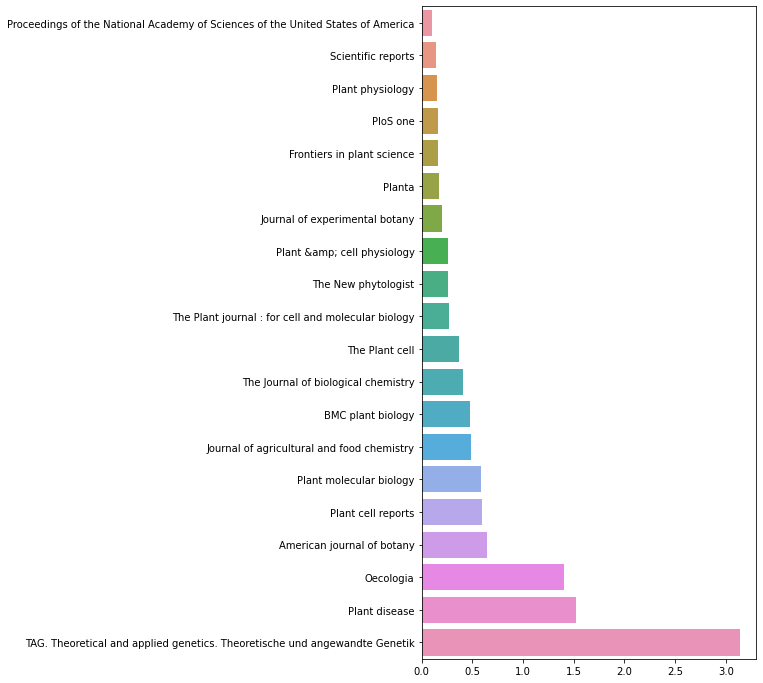

In [375]:
plt.figure(figsize=(6,12))
scaling_factor = 1e4
sns.barplot(y=diversity_jr.index, x=diversity_jr.values*scaling_factor, 
            orient='h')

### Diversity as 1 over variance of the precursor values

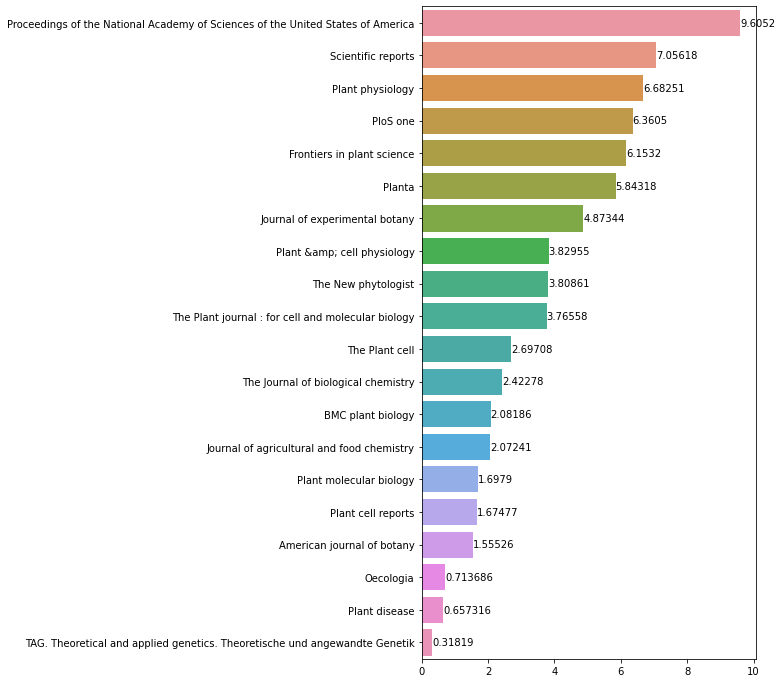

In [378]:
plt.figure(figsize=(6,12))
sns_bar = sns.barplot(y=diversity_jr.index, 
                      x=1/(diversity_jr.values*scaling_factor), 
                      orient='h')
for i in sns_bar.containers:
    sns_bar.bar_label(i,)

sns_bar.figure.savefig(work_dir / "fig4_3_journal_relative_topical_diversity.pdf",
                       bbox_inches='tight')


### Diversity based on precursor value distributions

In [351]:
df_toc_jr_topx_norm_mul.shape

(20, 90)

<AxesSubplot:>

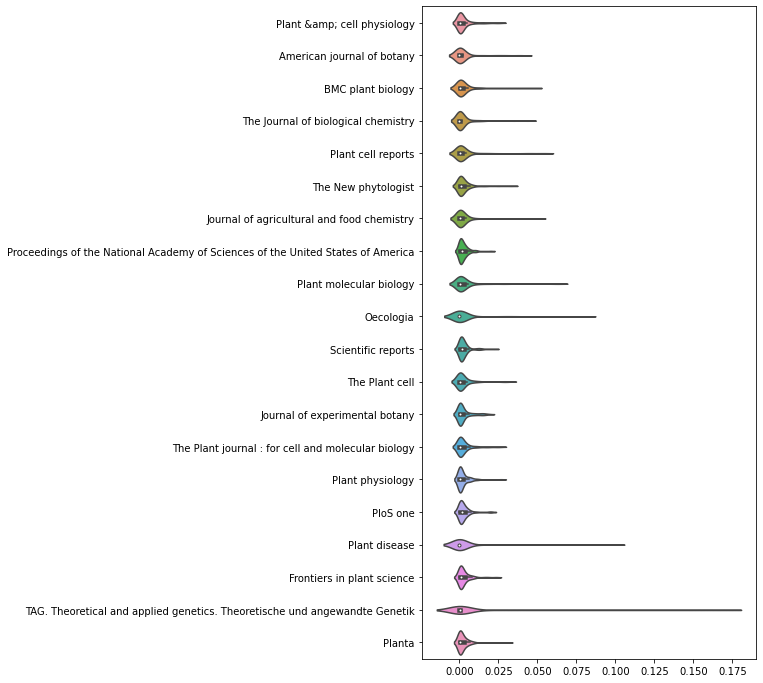

In [381]:
#https://stackoverflow.com/questions/46134113/seaborn-violin-plot-from-pandas-dataframe-each-column-its-own-separate-violin-p
# Does not work, want row-based: so transpose it
# Make horizontal plots
#https://stackoverflow.com/questions/48786906/cannot-make-seaborn-violin-plot-horizontal-python3-x
plt.figure(figsize=(6,12))
sns.violinplot(data=df_toc_jr_topx_norm_mul.transpose(), orient='h',)

<AxesSubplot:>

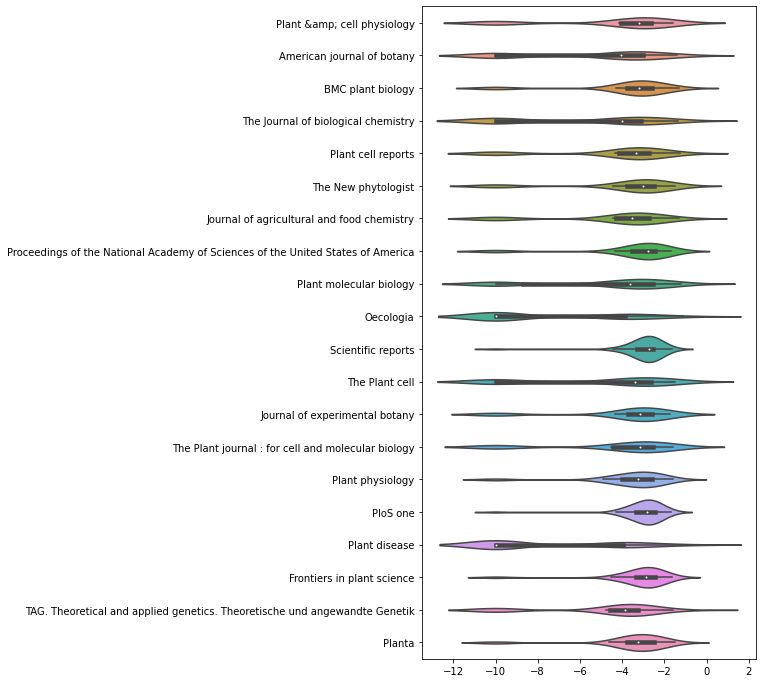

In [383]:
# log the values
#https://stackoverflow.com/questions/54389006/pandas-how-to-transform-all-numeric-columns-of-a-data-frame-into-logarithms
df_toc_jr_topx_norm_mul_log = pd.DataFrame()
for c in df_toc_jr_topx_norm_mul.columns:
    df_toc_jr_topx_norm_mul_log[c] = np.log10(df_toc_jr_topx_norm_mul[c].add(1e-10))

plt.figure(figsize=(6,12))
sns.violinplot(data=df_toc_jr_topx_norm_mul_log.transpose(), orient='h',)

# Not nice...

## ___Code dev___

### Get the dataframe for plotting the 2D graph

Get the dataframe used to plot this thing out, based on the codes in [here](https://github.com/MaartenGr/BERTopic/blob/master/bertopic/plotting/_topics.py):
- This is way too big and run into memory issue.

In [ ]:
#embed_ctfidf = topic_model.c_tf_idf.toarray()[indices]
embed_ctfidf = topic_term_matrix[indices]

In [ ]:
embed_scaled = MinMaxScaler().fit_transform(embed_ctfidf)

In [ ]:
# This takes ~3 min.
embed_umap   = UMAP(
  n_neighbors=2, n_components=2, metric='hellinger').fit_transform(embed_scaled)

In [ ]:
embed_df = pd.DataFrame({"x": embed_umap[:, 0], "y": embed_umap[:, 1],
                       "Topic": topic_list, "Words": words, "Size": frequencies})

In [ ]:
embed_df.head(3)

In [ ]:
embed_df.to_csv(work_dir / "table4_3_topic_relation_embedding_scaled_umap.tsv",
                sep='\t')

### Testing color network edges based on weights

[This](https://stackoverflow.com/questions/22967086/colouring-edges-by-weight-in-networkx)

In [108]:
import random

G = nx.gnp_random_graph(10,0.3)
for u,v,d in G.edges(data=True):
    d['weight'] = random.random()
nx.get_edge_attributes(G,'weight')

{(0, 2): 0.9092705526752157,
 (0, 3): 0.23714142405326133,
 (0, 8): 0.01427261365682908,
 (1, 7): 0.7607372752620604,
 (1, 8): 0.7628943363208747,
 (2, 8): 0.6961218090840797,
 (3, 6): 0.3324650124688602,
 (3, 8): 0.8482859950178446,
 (3, 9): 0.9168899665532759,
 (5, 6): 0.1349984286792224,
 (5, 7): 0.9284563413742747,
 (5, 8): 0.22767203047202156,
 (5, 9): 0.094669813069725,
 (6, 7): 0.5174454583247778}

In [109]:
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
type(edges), type(weights)

(tuple, tuple)

In [116]:
edges[:2], weights[:2]

(((0, 2), (0, 3)), (0.9092705526752157, 0.23714142405326133))

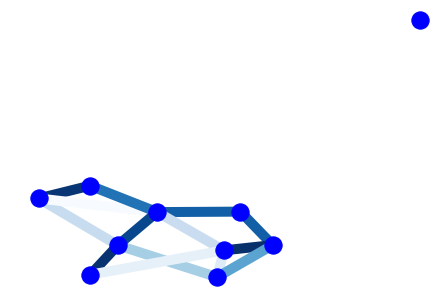

In [115]:
pos = nx.spring_layout(G)
nx.draw(G, pos, node_color='b', edgelist=edges, edge_color=weights, width=10.0, 
        edge_cmap=plt.cm.Blues)
